# Discovering Main Feature Differences Across Dosages

**Gregory Way, 2019**

We apply a two tailed t-test to test for differences between features in the 0.7 and 7 doses.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(cowplot))

In [2]:
doses <- c(0.7, 7)

axis_title_size <- 12
axis_text_size <- 10
strip_text_size <- 8
ggrepel_label_size <- 3

In [3]:
# Set column types for reading in data
batch_cols = readr::cols(
    .default = readr::col_double(),
    Metadata_Plate = readr::col_character(),
    Metadata_Well = readr::col_character(),
    Metadata_Assay_Plate_Barcode = readr::col_character(),
    Metadata_Plate_Map_Name = readr::col_character(),
    Metadata_Batch_Number = readr::col_integer(),
    Metadata_well_position = readr::col_character(),
    Metadata_CellLine = readr::col_character()
)

In [4]:
file <- file.path("data", "merged_intersected_variable_selected.csv")
data_df <- readr::read_csv(file, col_types = batch_cols) 

print(dim(data_df))
head(data_df, 3)

[1] 72 66


Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_Batch_Number,Metadata_well_position,Metadata_CellLine,Metadata_Dosage,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_0,⋯,Nuclei_Granularity_8_DNA,Nuclei_Granularity_9_DNA,Nuclei_Location_MaxIntensity_Y_RNA,Nuclei_RadialDistribution_MeanFrac_Mito_1of4,Nuclei_RadialDistribution_RadialCV_AGP_1of4,Nuclei_RadialDistribution_RadialCV_AGP_2of4,Nuclei_RadialDistribution_RadialCV_ER_1of4,Nuclei_RadialDistribution_RadialCV_Mito_1of4,Nuclei_Texture_Correlation_RNA_10_01,Nuclei_Texture_Correlation_RNA_10_03
HCT116bortezomib,B03,HCT116bortezomib,PlateMap_HCT116bortezomib,1,B03,WT,0,0.85727657,-0.3858899,⋯,-0.47024355,1.12160622,0.3762593,-1.759055,-0.68053556,-0.6446004,-0.5634461,-0.36363157,-1.43355903,-1.0812188
HCT116bortezomib,B04,HCT116bortezomib,PlateMap_HCT116bortezomib,1,B04,WT,0,0.68649109,0.5024000,⋯,-0.24886161,0.03721792,-0.5443365,-1.413942,-0.48795578,-0.6747323,-0.7727316,-0.22590011,-0.55055292,-0.5143410
HCT116bortezomib,B05,HCT116bortezomib,PlateMap_HCT116bortezomib,1,B05,WT,0,0.06455059,0.0033802,⋯,0.02263846,-0.38137450,-0.1406492,-1.343675,-0.09388887,-0.2848553,-0.6295427,-0.08707354,0.08001385,0.5337525


In [5]:
tstat <- c()
pval <- c()
all_features <- c()
for (feature in colnames(data_df)) {
    if (!grepl("Metadata_", feature)) {
        doseA <- data_df %>%
            dplyr::filter(Metadata_Dosage == doses[1],
                          Metadata_CellLine != "WT") %>%
            dplyr::pull(!!feature)
        
        doseB <- data_df %>%
            dplyr::filter(Metadata_Dosage == doses[2],
                          Metadata_CellLine != "WT") %>%
            dplyr::pull(!!feature)
        
        result <- t.test(doseA, doseB, var.equal = FALSE)
        
        all_features <- c(all_features, feature)
        tstat <- c(tstat, as.numeric(paste(result$statistic)))
        pval <- c(pval, result$p.value)
    }
}

In [6]:
result_df <- as.data.frame(cbind(tstat, pval))
result_df$neglog10p <- -log10(result_df$pval)
result_df$feature <- all_features
result_df <- result_df %>% dplyr::arrange(desc(neglog10p))

dim(result_df)
head(result_df, 3)

[1] 58  4

tstat,pval,neglog10p,feature
-13.013356,1.874475e-09,8.727120,Nuclei_AreaShape_Zernike_6_2
7.118472,1.440664e-06,5.841437,Cytoplasm_AreaShape_Zernike_3_1
-7.019841,2.848861e-06,5.545329,Nuclei_AreaShape_MaxFeretDiameter


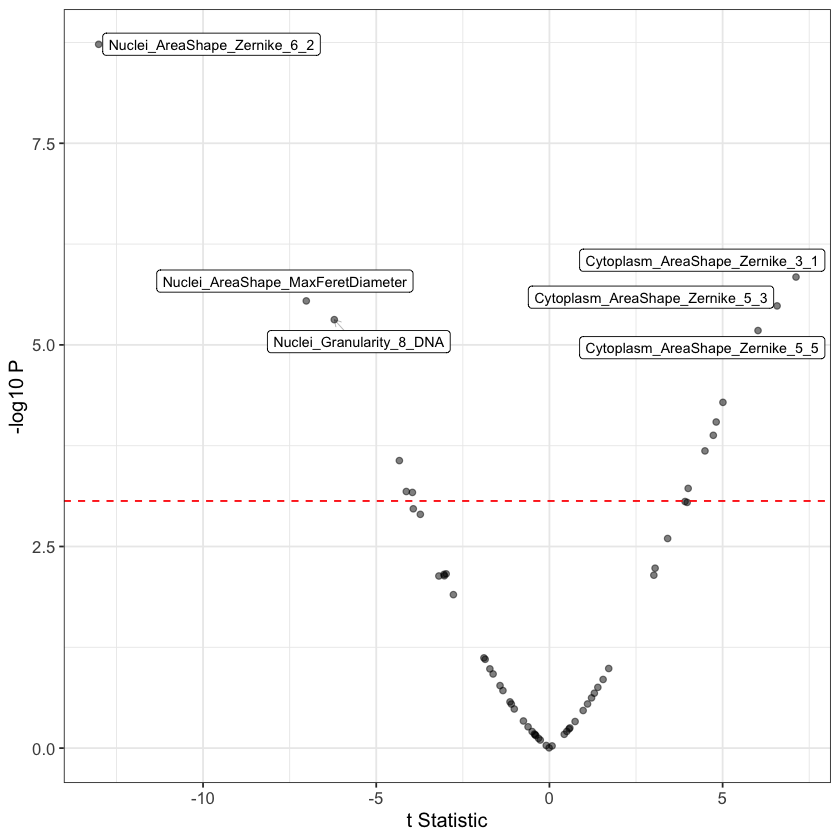

In [7]:
alpha_correction <- -log10(0.05 / dim(result_df)[1])
repel_logic <- result_df$neglog10p > alpha_correction * 1.5

ttest_gg <- ggplot(result_df, aes(x = tstat, y = neglog10p)) +
    geom_point(alpha = 0.5) +
    geom_hline(yintercept = alpha_correction,
               color = 'red',
               linetype = 'dashed') +
    xlab("t Statistic") +
    ylab("-log10 P") +
    geom_label_repel(data = subset(result_df, repel_logic),
                     arrow = arrow(length = unit(0.01, "npc")),
                     size = ggrepel_label_size,
                     segment.size = 0.1,
                     segment.alpha = 0.8,
                     force = 10,
                     aes(x = tstat, y = neglog10p, label = feature)) +
    theme_bw() +
    theme(axis.text = element_text(size = axis_text_size),
          axis.title = element_text(size = axis_title_size))

ttest_gg

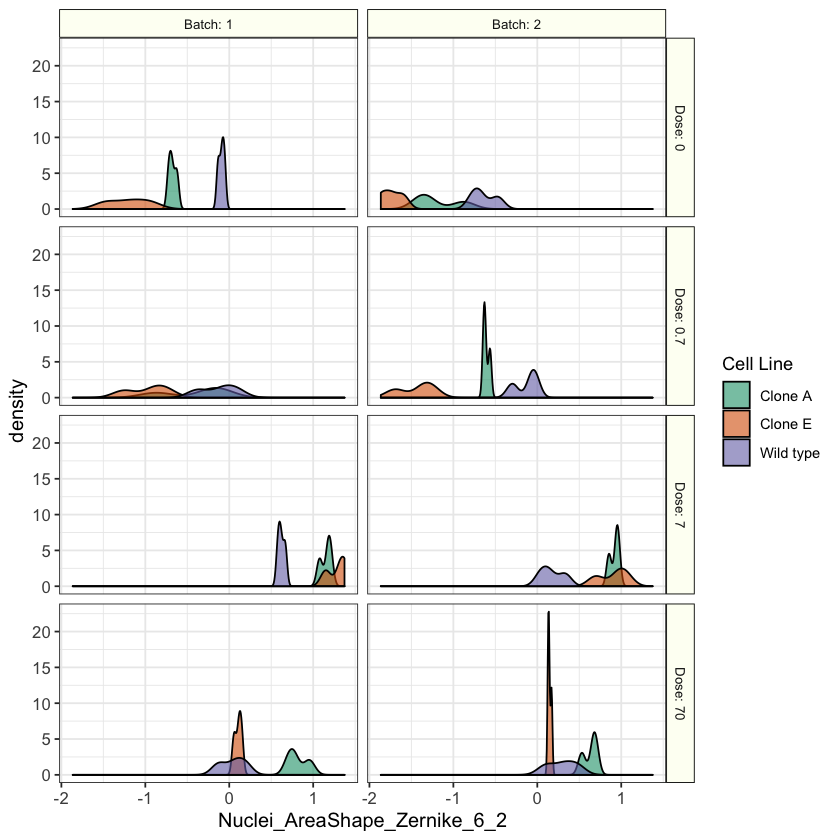

In [8]:
top_feature <- paste(result_df$feature[1])
append_batch <- function(string) paste("Batch:", string)
append_dose <- function(string) paste("Dose:", string)

distrib_gg <- ggplot(data_df, aes_string(x = `top_feature`)) +
    geom_density(aes(fill = Metadata_CellLine),
                 alpha = 0.6) +
    facet_grid(Metadata_Dosage ~ Metadata_Batch_Number,
               labeller = labeller(Metadata_Batch_Number = as_labeller(append_batch),
                                   Metadata_Dosage = as_labeller(append_dose))) +
    scale_fill_manual(name = "Cell Line",
                      labels = c("CloneA" = "Clone A",
                                 "CloneE" = "Clone E",
                                 "WT" = "Wild type"),
                      values = c("CloneA" = "#1b9e77",
                                 "CloneE" = "#d95f02",
                                 "WT" = "#7570b3")) +
    theme_bw() +
    theme(axis.text = element_text(size = axis_text_size),
          axis.title = element_text(size = axis_title_size),
          strip.text = element_text(size = strip_text_size),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

distrib_gg

## Combine Plots into Cowplot

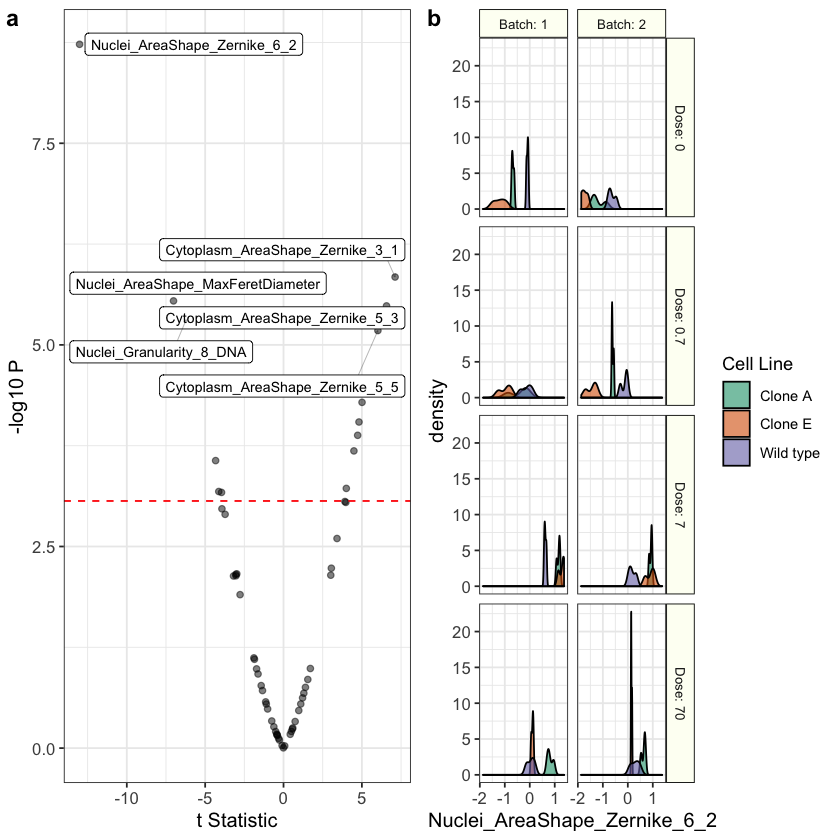

In [9]:
main_plot <- (
    cowplot::plot_grid(
        ttest_gg,
        distrib_gg,
        labels = c("a", "b"),
        ncol = 2,
        nrow = 1
    )
)

main_plot

In [10]:
file_base <- file.path("figures", "dosage_feature_figure")
for (extension in c('.png', '.pdf')) {
    ggsave(main_plot, filename = paste0(file_base, extension), height = 5, width = 10)
}